In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm

sys.path.append('/Users/jeanettemumford/Dropbox/Research/Projects/design_and_analysis/code_in_progress')

from utils import (calc_expected_run_num_by_chance, sample_shifted_truncated_exponential, 
                   est_eff_and_vif, est_psych_fitness, run_eff_sim)

In [2]:
def make_stop_flank_stroop_gng_timings(nc1, nc2, c1_dur, c2_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift):
    '''
    Produces a randomly ordered set of trials for the stop signal task, flanker, strop and go/nogo.
    Assumes a break between blocks of task.  Number of stop/go trials will be equal
    for each block of the task (nc1/(nbreaks + 1))
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) + 
      either a stop/go trial (duration = c1_dur/c2_dur) +
      blank screen (duration = blank_dur) + 
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      nc1: Total number of condition 1 (will be evenly split between blocks)
             Integer divisible by (nbreaks + 1)
      nc2: Total number of condition 2 (will be evenly split between blocks)
           Integer divisible by (nbreaks + 1)
      c1_dur: Duration of a stop trial
      c2_dur: Duration of a go trial
      blank_dur:  Duration of blank screen after stop/go stimulus offset
      nbreaks: Total number of breaks (blocks = nbreaks + 1)
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
       Includes stop/go/break message timings
    '''
    nblocks = nbreaks + 1
    ntrials = nc1 + nc2
    ntrials_per_block = int(ntrials/nblocks)
    nc1_per_block = int(nc1 / (nblocks))
    nc2_per_block = int(nc2 / (nblocks))
    isi_vals, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                    isi_shift, ntrials)

    # fragments = all sub-components of the run (go/stop/fixation/blank/break_message)
    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        stim_type_block = np.random.permutation(np.concatenate((np.repeat(['cond1'], nc1_per_block),
                                                        np.repeat(['cond2'], nc2_per_block))))
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_block[cur_trial]
            stim_dur_cur_trial = c1_dur if cur_stim_type == 'cond1' else c2_dur
            fragment_durations.extend([isi_vals[isi_count], stim_dur_cur_trial, blank_dur])
            fragment_labels.extend(['isi_fix', cur_stim_type, 'blank'])
            isi_count = isi_count + 1
        #Add break
        fragment_durations.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[events_data['trial_type'].str.contains('cond1|cond2|break_message')==True]
    return events_data

## Stop Signal

In [3]:
events_inputs = {
    'nc1': 60,
    'nc2': 120,
    'c1_dur': 1,
    'c2_dur': 1,
    'blank_dur': .5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}


tr = 1.49
total_time = 10*60
contrasts = {'stop': 'cond1',
             'go': 'cond2',
             'stop-go': 'cond1 - cond2',
             'task': '.5*cond1+.5*cond2'}

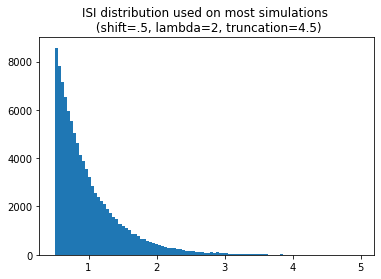

theoretical mean
0.9994445873382422
quartiles
[0.5   0.644 0.846 1.194 4.973]


In [4]:
nsamp = 100000 
samples, theoretical_mean = sample_shifted_truncated_exponential(events_inputs['isi_exp_lam'], events_inputs['isi_truncation'], 
                                                                 events_inputs['isi_shift'], nsamp)
isi_quartiles = np.round(np.quantile(samples, [0, .25, .5, .75, 1]), 3)

plt.hist(samples, 100)
plt.title('ISI distribution used on most simulations \n (shift=.5, lambda=2, truncation=4.5)')
plt.show()
print('theoretical mean')
print(theoretical_mean)
print('quartiles')
print(isi_quartiles)

In [5]:
trials_psych_assess_map = {'cond1': '1', 'cond2': '2'}

unpermuted_trials = np.concatenate([np.repeat('1', events_inputs['nc1']/3), 
                                    np.repeat('2', events_inputs['nc2']/3)],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2']:
    avg_trial_repeats_info[f'{val}_run_counts'] = avg_trial_repeats_info[f'{val}_run_counts'] * 3
print(avg_trial_repeats_info.loc[:25, :])

    run_length  1_run_counts  2_run_counts
0          1.0       27.1476       13.4658
1          2.0        9.0732        9.6924
2          3.0        2.8506        6.3990
3          4.0        0.8850        4.1658
4          5.0        0.2604        2.7462
5          6.0        0.0774        1.7916
6          7.0        0.0180        1.1526
7          8.0        0.0036        0.7506
8          9.0        0.0006        0.4566
9         10.0        0.0012        0.2736
10        11.0        0.0000        0.1764
11        12.0        0.0000        0.1050
12        13.0        0.0000        0.0612
13        14.0        0.0000        0.0372
14        15.0        0.0000        0.0216
15        16.0        0.0000        0.0132
16        17.0        0.0000        0.0030
17        18.0        0.0000        0.0018
18        19.0        0.0000        0.0024
19        20.0        0.0000        0.0012
20        21.0        0.0000        0.0006
21        22.0        0.0000        0.0000
22        2

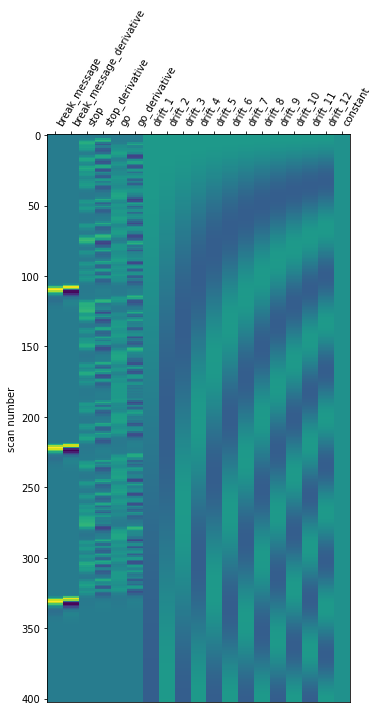

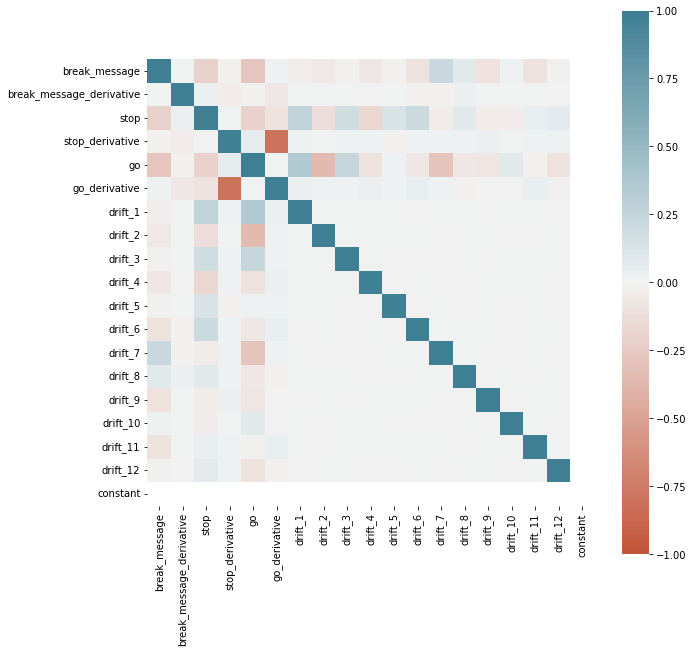

In [6]:
events_ts = make_stop_flank_stroop_gng_timings(**events_inputs)
_, _, desmat = est_eff_and_vif(events_ts, tr, total_time, contrasts)

name_swap = {
    'cond1': 'stop',
    'cond2': 'go'
}

desmat.columns = desmat.columns.to_series().replace(name_swap, regex=True)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [7]:
nsim = 250
output_setting1, events_setting1 = run_eff_sim(nsim, events_inputs, make_stop_flank_stroop_gng_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map)

In [8]:
pd.set_option('display.width', 1000)

summary_names = [f'eff_{name}' for name in contrasts.keys()] + \
                [f'vif_{name}' for name in contrasts.keys()] + \
                ['scan_length']

eff_vif_summaries = {}
eff_vif_summaries['setting1']= np.round(output_setting1[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_stop  eff_go  eff_stop-go  eff_task  vif_stop  vif_go  vif_stop-go  vif_task  scan_length
0.05      1.86    2.33         3.26      2.42      2.22    2.72         1.06      4.53       501.77
0.50      2.18    2.63         4.02      2.80      2.67    3.22         1.13      5.15       511.69
0.95      2.51    3.03         4.93      3.16      3.20    3.82         1.29      5.87       521.84


### Stop signal, decrease fixation around break messages

In [9]:
events_inputs_decrease_fix = {
    'nc1': 60,
    'nc2': 120,
    'c1_dur': 1,
    'c2_dur': 1,
    'blank_dur': .5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 2,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 2,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

In [10]:
nsim = 250
output_decrease_fix, events_decrease_fix = run_eff_sim(nsim, events_inputs_decrease_fix, make_stop_flank_stroop_gng_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map)

In [11]:
eff_vif_summaries['decrease_fix']= np.round(output_decrease_fix[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_stop  eff_go  eff_stop-go  eff_task  vif_stop  vif_go  vif_stop-go  vif_task  scan_length
0.05      1.86    2.33         3.26      2.42      2.22    2.72         1.06      4.53       501.77
0.50      2.18    2.63         4.02      2.80      2.67    3.22         1.13      5.15       511.69
0.95      2.51    3.03         4.93      3.16      3.20    3.82         1.29      5.87       521.84
Results for decrease_fix
      eff_stop  eff_go  eff_stop-go  eff_task  vif_stop  vif_go  vif_stop-go  vif_task  scan_length
0.05      1.24    1.38         3.30      1.46      3.31    3.94         1.07      6.92       481.05
0.50      1.46    1.66         4.07      1.71      4.21    4.99         1.15      8.28       491.91
0.95      1.73    1.97         4.95      2.06      5.29    6.25         1.29      9.93       502.88


## Flanker (exactly same as Stroop)

In [12]:
events_inputs_flanker = {
    'nc1': 60,
    'nc2': 60,
    'c1_dur': 1,
    'c2_dur': 1,
    'blank_dur': .5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}


tr = 1.49
total_time = 6*60
contrasts_flanker = {'congruent': 'cond1',
             'incongruent': 'cond2',
             'incongruent-congruent': 'cond1 - cond2',
             'task': '.5*cond1+.5*cond2'}

In [13]:
trials_psych_assess_map = {'cond1': '1', 'cond2': '2'}

unpermuted_trials = np.concatenate([np.repeat('1', events_inputs_flanker['nc1']/3), 
                                    np.repeat('2', events_inputs_flanker['nc2']/3)],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2']:
    avg_trial_repeats_info[f'{val}_run_counts'] = avg_trial_repeats_info[f'{val}_run_counts'] * 3
print(avg_trial_repeats_info.loc[:25, :])

    run_length  1_run_counts  2_run_counts
0          1.0       15.3990       15.4050
1          2.0        8.0340        8.1012
2          3.0        3.8976        3.8970
3          4.0        1.8822        1.8498
4          5.0        0.8406        0.8652
5          6.0        0.3936        0.3660
6          7.0        0.1458        0.1398
7          8.0        0.0648        0.0762
8          9.0        0.0288        0.0282
9         10.0        0.0096        0.0108
10        11.0        0.0048        0.0042
11        12.0        0.0012        0.0012
12        13.0        0.0012        0.0000
13        14.0        0.0000        0.0000
14        15.0        0.0000        0.0000
15        16.0        0.0000        0.0000
16        17.0        0.0000        0.0000
17        18.0        0.0000        0.0000
18        19.0        0.0000        0.0000
19        20.0        0.0000        0.0000


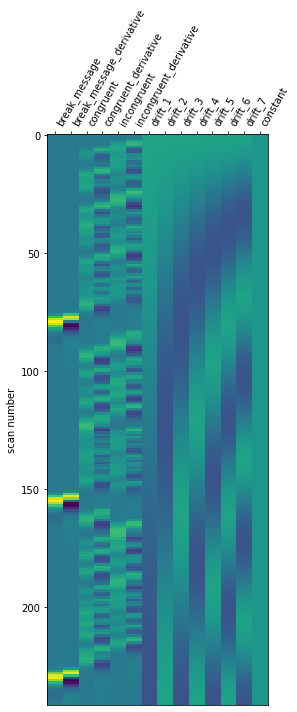

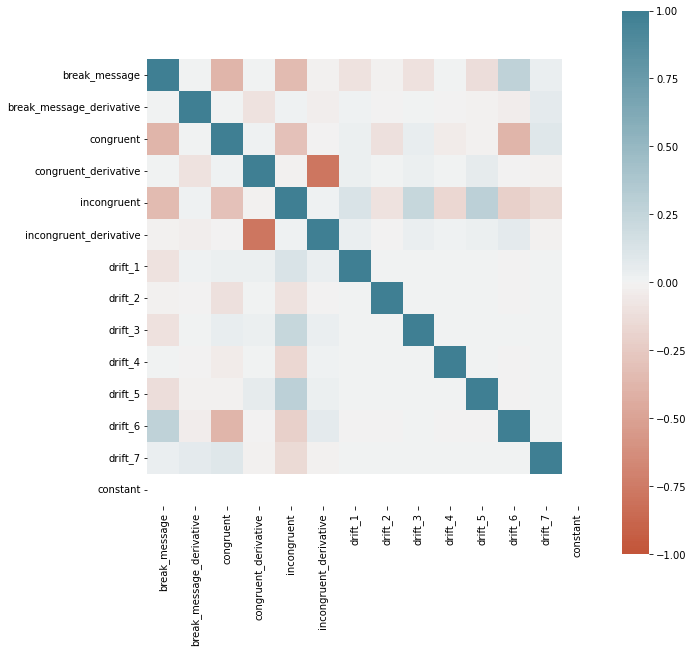

In [14]:
events_flanker = make_stop_flank_stroop_gng_timings(**events_inputs_flanker)
_, _, desmat_flanker = est_eff_and_vif(events_flanker, tr, total_time, contrasts_flanker)

name_swap = {
    'cond1': 'congruent',
    'cond2': 'incongruent'
}

desmat_flanker.columns = desmat_flanker.columns.to_series().replace(name_swap, regex=True)

plot_design_matrix(desmat_flanker)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_flanker.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [15]:
nsim = 250
output_setting1_flanker, events_setting1_flanker = run_eff_sim(nsim, events_inputs_flanker, make_stop_flank_stroop_gng_timings, 
                               contrasts_flanker, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map)

In [16]:
pd.set_option('display.width', 1000)

summary_names = [f'eff_{name}' for name in contrasts_flanker.keys()] + \
                [f'vif_{name}' for name in contrasts_flanker.keys()] + \
                ['scan_length']

eff_vif_summaries_flanker = {}
eff_vif_summaries_flanker['setting1']= np.round(output_setting1_flanker[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries_flanker.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_congruent  eff_incongruent  eff_incongruent-congruent  eff_task  vif_congruent  vif_incongruent  vif_incongruent-congruent  vif_task  scan_length
0.05           1.65             1.63                       2.37      2.06           2.12             2.09                       1.03      2.23       353.15
0.50           1.98             1.99                       3.07      2.36           2.48             2.47                       1.10      2.61       361.18
0.95           2.36             2.38                       3.77      2.75           3.01             3.05                       1.24      2.99       370.69


## Go/NoGo


In [17]:
events_inputs_gng = {
    'nc1': 162,
    'nc2': 27,
    'c1_dur': 1,
    'c2_dur': 1,
    'blank_dur': .5,
    'nbreaks': 2,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}


tr = 1.49
total_time = 10*60
contrasts_gng = {'go': 'cond1',
             'nogo': 'cond2',
             'nogo-go': 'cond2 - cond1',
             'task': '.5*cond1+.5*cond2'}

In [18]:
trials_psych_assess_map = {'cond1': '1', 'cond2': '2'}

unpermuted_trials = np.concatenate([np.repeat('1', events_inputs_gng['nc1']/3), 
                                    np.repeat('2', events_inputs_gng['nc2']/3)],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2']:
    avg_trial_repeats_info[f'{val}_run_counts'] = avg_trial_repeats_info[f'{val}_run_counts'] * 3
print(avg_trial_repeats_info.loc[:25, :])

    run_length  1_run_counts  2_run_counts
0          1.0        3.3246       19.9956
1          2.0        3.2262        2.7498
2          3.0        2.8566        0.3222
3          4.0        2.3778        0.0330
4          5.0        2.1444        0.0024
5          6.0        1.7862        0.0000
6          7.0        1.5060        0.0000
7          8.0        1.3368        0.0000
8          9.0        1.1154        0.0000
9         10.0        0.9582        0.0000
10        11.0        0.7806        0.0000
11        12.0        0.6768        0.0000
12        13.0        0.5892        0.0000
13        14.0        0.4692        0.0000
14        15.0        0.4224        0.0000
15        16.0        0.3360        0.0000
16        17.0        0.2646        0.0000
17        18.0        0.2160        0.0000
18        19.0        0.1770        0.0000
19        20.0        0.1494        0.0000
20        21.0        0.1260        0.0000
21        22.0        0.0960        0.0000
22        2

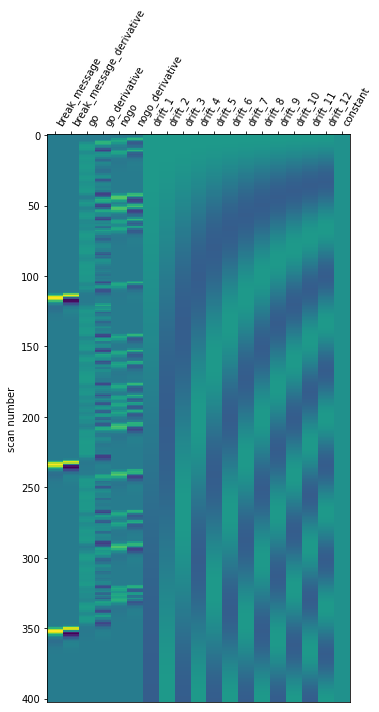

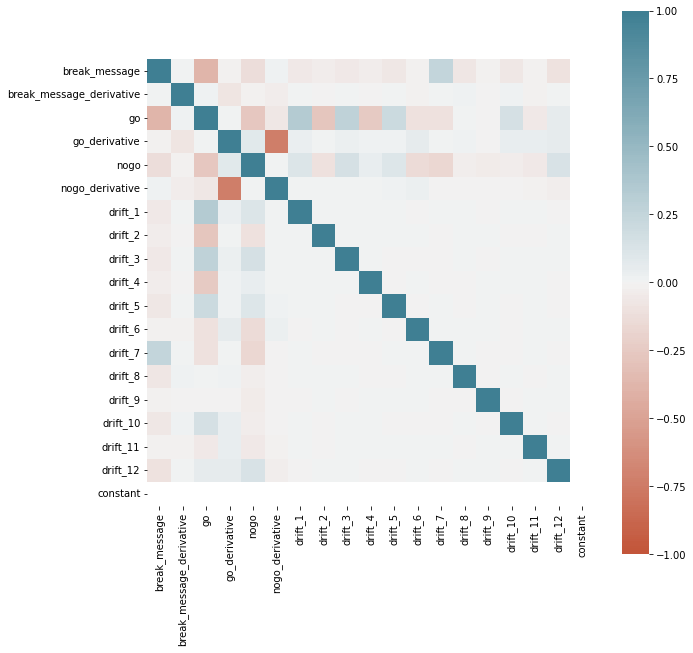

In [19]:
events_gng = make_stop_flank_stroop_gng_timings(**events_inputs_gng)
_, _, desmat_gng = est_eff_and_vif(events_gng, tr, total_time, contrasts_gng)

name_swap = {
    'cond1': 'go',
    'cond2': 'nogo'
}

desmat_gng.columns = desmat_gng.columns.to_series().replace(name_swap, regex=True)

plot_design_matrix(desmat_gng)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_gng.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [20]:
nsim = 250
output_setting1_gng, events_setting1_gng = run_eff_sim(nsim, events_inputs_gng, make_stop_flank_stroop_gng_timings, 
                               contrasts_gng, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map)

In [21]:
summary_names = [f'eff_{name}' for name in contrasts_gng.keys()] + \
                [f'vif_{name}' for name in contrasts_gng.keys()] + \
                ['scan_length']

eff_vif_summaries_gng = {}
eff_vif_summaries_gng['setting1']= np.round(output_setting1_gng[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries_gng.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_go  eff_nogo  eff_go-nogo  eff_task  vif_go  vif_nogo  vif_go-nogo  vif_task  scan_length
0.05    2.45      1.29         1.99      2.14    2.68      1.67         1.05      4.21       523.88
0.50    2.76      1.50         2.38      2.45    3.06      1.95         1.12      4.84       534.77
0.95    3.18      1.77         2.92      2.79    3.44      2.23         1.25      5.44       545.70
